# Evaluation


In [3]:
# Standard libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import glob
import re
from IPython.display import display
from collections import Counter
import time

# For similarity calculations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# For KNN specifically
from sklearn.neighbors import NearestNeighbors

# For evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns  # For better visualizations

# Directory 
fp_directory = "fingerprints_chunks"
query_dir = os.path.join(fp_directory, "query")
reference_dir = os.path.join(fp_directory, "reference")

In [12]:
def load_fingerprints():
    # Load the fingerprint database
    db_path = os.path.join(fp_directory, "fingerprint_db.json")
    if os.path.exists(db_path):
        with open(db_path, 'r') as f:
            fingerprint_db = json.load(f)
        print(f"Loaded fingerprint database with {len(fingerprint_db)} entries")
    else:
        print(f"Database not found at {db_path}, scanning files directly")
        fingerprint_db = {}
    
    # Load query fingerprints
    query_files = glob.glob(os.path.join(query_dir, "*_fp.json"))
    query_fingerprints = {}
    
    print(f"Loading {len(query_files)} query fingerprints...")
    for query_file in tqdm(query_files):
        with open(query_file, 'r') as f:
            fp_data = json.load(f)
        
        # Extract video number and ID from filename
        filename = os.path.basename(query_file)
        match = re.search(r'(\d+)\[(.*?)\]_.*?_fp\.json', filename)
        if match:
            video_number = match.group(1)
            video_id = match.group(2)
            # Create a key for this fingerprint (Easier retrieval)
            key = f"{video_number}_{video_id}"
            
            query_fingerprints[key] = {
                "file": query_file,
                "data": fp_data,
                "video_id": video_id,
                "video_number": video_number
            }
    
    # Load reference fingerprints
    ref_files = glob.glob(os.path.join(reference_dir, "*_fp.json"))
    ref_fingerprints = {}
    
    print(f"Loading {len(ref_files)} reference fingerprints...")
    for ref_file in tqdm(ref_files):
        with open(ref_file, 'r') as f:
            fp_data = json.load(f)
        
        # Extract video number and reference ID from filename
        filename = os.path.basename(ref_file)
        match = re.search(r'(\d+)\[(.*?)\]_.*?reference_(.*?)_fp\.json', filename)
        if match:
            video_number = match.group(1)
            query_id = match.group(2)
            ref_id = match.group(3)
            
            # Create a key for this fingerprint (Easier retrieval)
            key = f"{video_number}_{ref_id}"
            
            ref_fingerprints[key] = {
                "file": ref_file,
                "data": fp_data,
                "video_id": ref_id,
                "query_id": query_id,
                "video_number": video_number
            }
    
    return query_fingerprints, ref_fingerprints, fingerprint_db

In [7]:
def compute_similarity(query_fp, ref_fp, normalize_vectors=True):
    # Get all segment fingerprints
    query_segments = query_fp["data"]["segment_fingerprints"]
    ref_segments = ref_fp["data"]["segment_fingerprints"]
    
    # Extract fingerprint vectors
    query_vectors = np.array([seg["fingerprint"] for seg in query_segments])
    ref_vectors = np.array([seg["fingerprint"] for seg in ref_segments])
    
    # Normalize vectors if requested (recommended for cosine similarity)
    if normalize_vectors:
        # Handle empty arrays safely
        if query_vectors.size > 0:
            query_vectors = normalize(query_vectors)
        if ref_vectors.size > 0:
            ref_vectors = normalize(ref_vectors)
    
    # Calculate pairwise cosine similarity
    similarity_matrix = cosine_similarity(query_vectors, ref_vectors)
    
    # Get maximum similarity for each query segment
    max_similarities = np.max(similarity_matrix, axis=1) if similarity_matrix.size > 0 else np.array([])
    
    # Overall similarity is average of max similarities
    overall_similarity = np.mean(max_similarities) if max_similarities.size > 0 else 0.0
    
    return {
        "overall_similarity": overall_similarity,
        "similarity_matrix": similarity_matrix,
        "max_similarities": max_similarities
    }

### Evaluate query-reference pairs - Cosine similarity

In [8]:

def evaluate_query_reference(normalize_vectors=True, top_n=5, similarity_threshold=70):
    """
    Evaluate each query against ALL reference fingerprints, find top N matches,
    and identify if the correct reference is among them.
    
    Args:
        normalize_vectors: Whether to normalize fingerprint vectors
        top_n: Number of top matches to return per query
        similarity_threshold: Threshold for considering a match 'good' (0-100 scale)
        
    Returns:
        DataFrame with evaluation results and performance metrics
    """
    # Load fingerprints
    query_fps, ref_fps, fp_db = load_fingerprints()
    
    print(f"Loaded {len(query_fps)} query and {len(ref_fps)} reference fingerprints")
    
    # Prepare results container
    all_results = []
    evaluation_metrics = []
    
    # Process each query fingerprint
    for query_key, query_fp in tqdm(query_fps.items()):
        video_number = query_fp["video_number"]
        query_id = query_fp["video_id"]
        
        # Determine the ground truth reference(s) for this query
        # This assumes references with the same video_number are the correct matches
        ground_truth_refs = [ref_key for ref_key, ref in ref_fps.items() 
                           if ref["video_number"] == video_number]
        
        # Compare against ALL references
        query_results = []
        
        for ref_key, ref_fp in ref_fps.items():
            # Compute similarity between this query and reference
            similarity_result = compute_similarity(query_fp, ref_fp, normalize_vectors)
            
            # Store results
            query_results.append({
                'query_key': query_key,
                'ref_key': ref_key,
                'query_id': query_id,
                'ref_id': ref_fp["video_id"],
                'ref_video_number': ref_fp["video_number"],
                'overall_similarity': similarity_result["overall_similarity"] * 100,  # Convert to percentage
                'is_correct_match': ref_key in ground_truth_refs
            })
        
        # Sort results by similarity (highest first) and get top N
        query_results.sort(key=lambda x: x['overall_similarity'], reverse=True)
        top_matches = query_results[:top_n]
        
        # Add all top matches to the results list
        all_results.extend(top_matches)
        
        # Calculate evaluation metrics for this query
        correct_in_top_n = any(match['is_correct_match'] for match in top_matches)
        
        # Find position of correct match (if any)
        correct_position = -1
        for i, result in enumerate(query_results):
            if result['is_correct_match']:
                correct_position = i + 1  # 1-based position
                break
                
        # Find similarity of correct match
        correct_match = next((r for r in query_results if r['is_correct_match']), None)
        correct_match_similarity = correct_match['overall_similarity'] if correct_match else 0
        
        # Add evaluation metrics
        evaluation_metrics.append({
            'query_key': query_key,
            'query_id': query_id,
            'video_number': video_number,
            'correct_in_top_n': correct_in_top_n,
            'correct_match_position': correct_position,
            'correct_match_similarity': correct_match_similarity,
            'top_match_similarity': top_matches[0]['overall_similarity'] if top_matches else 0,
            'top_match_is_correct': top_matches[0]['is_correct_match'] if top_matches else False,
            'num_matches_above_threshold': sum(1 for r in query_results if r['overall_similarity'] >= similarity_threshold)
        })
        
        # Print top matches for this query
        print(f"\nTop {top_n} matches for Query {query_key} (Video {video_number}):")
        for i, match in enumerate(top_matches):
            correct = "✓" if match['is_correct_match'] else "✗"
            print(f"{i+1}. {match['ref_key']} - Similarity: {match['overall_similarity']:.2f}% {correct}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Create evaluation summary
    eval_df = pd.DataFrame(evaluation_metrics)
    
    # Calculate overall metrics
    recall_at_n = eval_df['correct_in_top_n'].mean() * 100
    top_1_accuracy = eval_df['top_match_is_correct'].mean() * 100
    
    print("\n=== Overall Performance ===")
    print(f"Recall@{top_n}: {recall_at_n:.2f}% (correct reference in top {top_n})")
    print(f"Top-1 Accuracy: {top_1_accuracy:.2f}% (correct reference is the top match)")
    print(f"Mean Reciprocal Rank: {(1/eval_df['correct_match_position']).mean():.4f}")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distribution of similarities for correct vs incorrect matches
    plt.subplot(2, 2, 1)
    correct_sims = results_df[results_df['is_correct_match']]['overall_similarity']
    incorrect_sims = results_df[~results_df['is_correct_match']]['overall_similarity']
    
    plt.hist([correct_sims, incorrect_sims], bins=20, 
             label=['Correct Matches', 'Incorrect Matches'], alpha=0.7)
    plt.axvline(x=similarity_threshold, color='r', linestyle='--', label=f'{similarity_threshold}% Threshold')
    plt.title('Distribution of Similarities')
    plt.xlabel('Similarity (%)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Positions of correct matches
    plt.subplot(2, 2, 2)
    position_counts = eval_df['correct_match_position'].value_counts().sort_index()
    position_counts = position_counts[position_counts.index > 0]  # Filter out -1 (not found)
    plt.bar(position_counts.index, position_counts.values)
    plt.title('Position of Correct Matches')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.xticks(range(1, min(11, position_counts.index.max() + 1)))
    plt.grid(alpha=0.3, axis='y')
    
    # Plot 3: Top match similarity vs. correct match similarity
    plt.subplot(2, 2, 3)
    plt.scatter(eval_df['top_match_similarity'], eval_df['correct_match_similarity'], alpha=0.7)
    plt.plot([0, 100], [0, 100], 'r--', label='Identity Line')
    plt.title('Top Match vs. Correct Match Similarity')
    plt.xlabel('Top Match Similarity (%)')
    plt.ylabel('Correct Match Similarity (%)')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Plot 4: Accuracy by similarity threshold
    plt.subplot(2, 2, 4)
    thresholds = np.linspace(0, 100, 21)
    accuracies = []
    
    for thresh in thresholds:
        # For each threshold, calculate percentage where top match is correct AND above threshold
        acc = ((eval_df['top_match_is_correct']) & 
               (eval_df['top_match_similarity'] >= thresh)).mean() * 100
        accuracies.append(acc)
    
    plt.plot(thresholds, accuracies)
    plt.axvline(x=similarity_threshold, color='r', linestyle='--', label=f'{similarity_threshold}% Threshold')
    plt.title('Accuracy vs. Similarity Threshold')
    plt.xlabel('Similarity Threshold (%)')
    plt.ylabel('Accuracy (%)')
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df, eval_df

Database not found at fingerprints_chunks/chunk_fingerprint_db.json, scanning files directly
Loading 74 query fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loading 74 reference fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loaded 15 query and 35 reference fingerprints


  0%|          | 0/15 [00:00<?, ?it/s]


Top 5 matches for Query 000_YzHOD9t1fKM (Video 000):
1. 014_6O8ij0TELJk - Similarity: 96.98% ✗
2. 004_k1QpRMBKCWQ - Similarity: 96.92% ✗
3. 006_Ik21AAjmHVY - Similarity: 96.90% ✗
4. 002_e3T-KIiz4Jo - Similarity: 96.86% ✗
5. 010_Tu8SH6FbN0Q - Similarity: 96.83% ✗

Top 5 matches for Query 001_xVknxiEDy-s (Video 001):
1. 004_k1QpRMBKCWQ - Similarity: 97.47% ✗
2. 014_6O8ij0TELJk - Similarity: 97.41% ✗
3. 002_ekCp0ujVjEI - Similarity: 97.14% ✗
4. 002_e3T-KIiz4Jo - Similarity: 97.12% ✗
5. 006_Ik21AAjmHVY - Similarity: 97.00% ✗

Top 5 matches for Query 002_izixWy82qLs (Video 002):
1. 010_Tu8SH6FbN0Q - Similarity: 98.71% ✗
2. 004_k1QpRMBKCWQ - Similarity: 98.62% ✗
3. 006_Ik21AAjmHVY - Similarity: 98.58% ✗
4. 002_ekCp0ujVjEI - Similarity: 98.28% ✓
5. 002_e3T-KIiz4Jo - Similarity: 98.28% ✓

Top 5 matches for Query 003_ZupxakzVLEk (Video 003):
1. 004_k1QpRMBKCWQ - Similarity: 97.17% ✗
2. 006_Ik21AAjmHVY - Similarity: 97.09% ✗
3. 002_e3T-KIiz4Jo - Similarity: 97.06% ✗
4. 014_6O8ij0TELJk - Similar

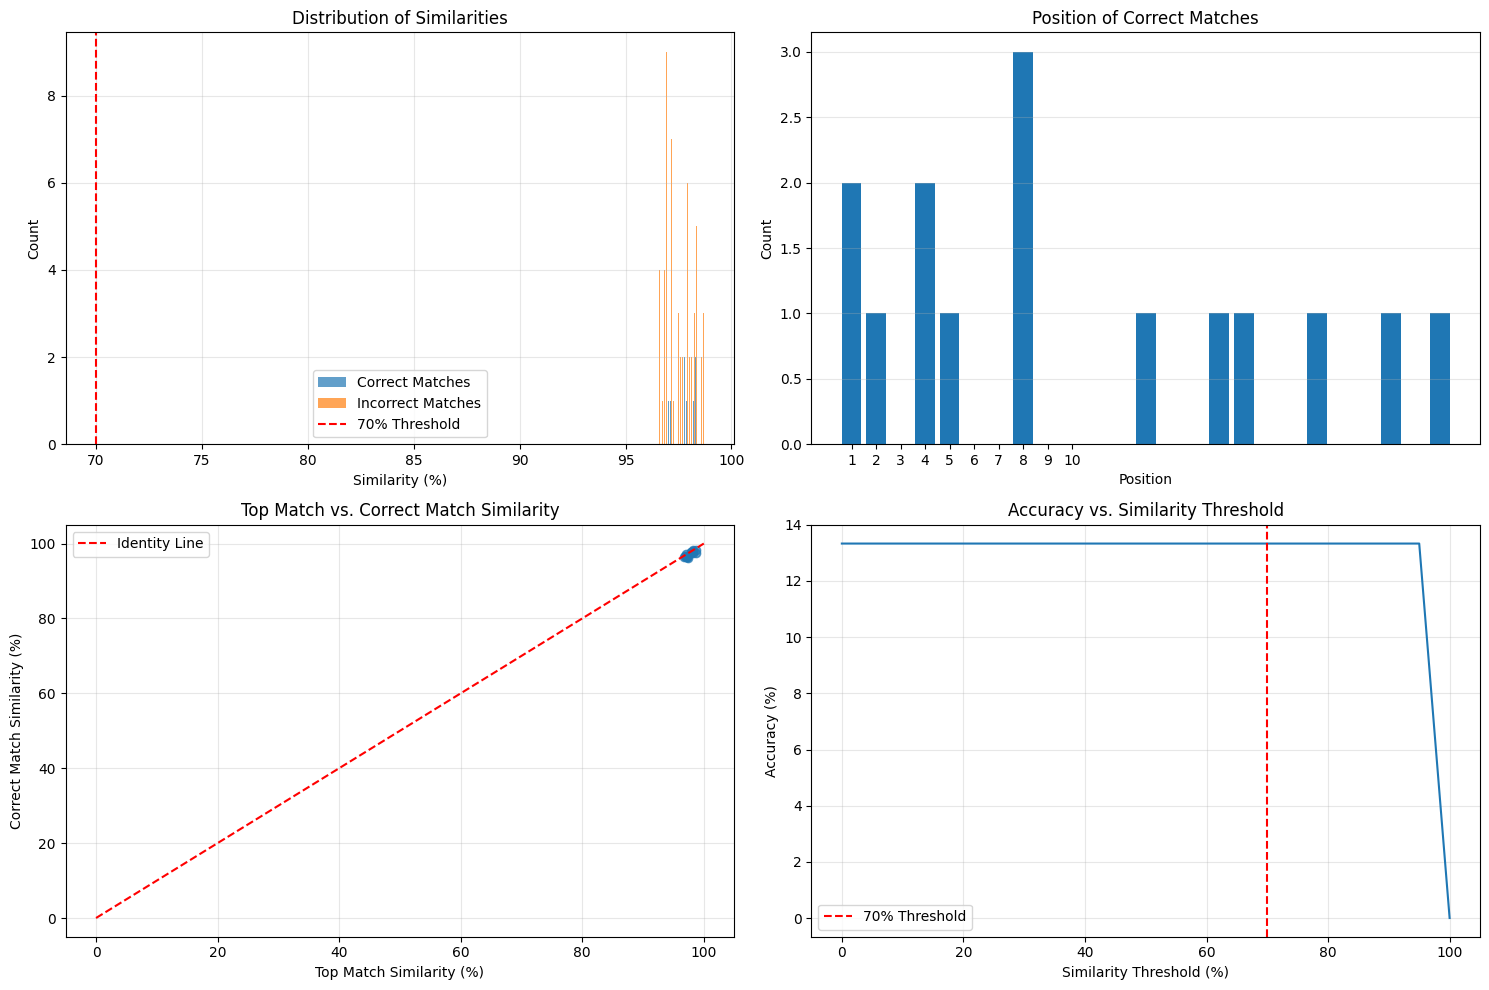


Evaluation Summary:


,query_key,correct_in_top_n,correct_match_position,top_match_similarity,top_match_is_correct
0,000_YzHOD9t1fKM,False,8,96.976376,False
1,001_xVknxiEDy-s,False,25,97.471258,False
2,002_izixWy82qLs,True,4,98.707519,False
3,003_ZupxakzVLEk,False,23,97.168900,False
4,004_MnfnAptvNQ,True,1,98.200789,True
5,005_CUKrxK3WH-A,False,17,97.247177,False
6,006_e5LH6WIIlSs,True,2,97.815619,False
7,007_eQ7YB3rgAmA,False,16,97.105769,False
8,008_juCoUIB92h8,False,8,96.688190,False
9,009_lAwqPWYN2UU,True,4,97.865463,False



Detailed Match Results (sample):


,query_key,ref_key,overall_similarity,is_correct_match
0,000_YzHOD9t1fKM,014_6O8ij0TELJk,96.976376,False
1,000_YzHOD9t1fKM,004_k1QpRMBKCWQ,96.924988,False
2,000_YzHOD9t1fKM,006_Ik21AAjmHVY,96.900718,False
3,000_YzHOD9t1fKM,002_e3T-KIiz4Jo,96.861801,False
4,000_YzHOD9t1fKM,010_Tu8SH6FbN0Q,96.833435,False
5,001_xVknxiEDy-s,004_k1QpRMBKCWQ,97.471258,False
6,001_xVknxiEDy-s,014_6O8ij0TELJk,97.414953,False
7,001_xVknxiEDy-s,002_ekCp0ujVjEI,97.139081,False
8,001_xVknxiEDy-s,002_e3T-KIiz4Jo,97.123010,False
9,001_xVknxiEDy-s,006_Ik21AAjmHVY,96.999300,False


In [9]:
# Call the evaluation function with default parameters
results_df, eval_df = evaluate_query_reference(
    normalize_vectors=True,  # Apply normalization to the fingerprint vectors
    top_n=5,                 # Show top 5 matches per query
    similarity_threshold=70  # Mark 70% as the threshold for "good" matches
)

# To examine the evaluation results in more detail
print("\nEvaluation Summary:")
display(eval_df[['query_key', 'correct_in_top_n', 'correct_match_position', 
                'top_match_similarity', 'top_match_is_correct']].head(10))

# To see the detailed match results
print("\nDetailed Match Results (sample):")
display(results_df[['query_key', 'ref_key', 'overall_similarity', 'is_correct_match']].head(10))

# Save results to CSV for further analysis
results_df.to_csv("results/fingerprint_match_results.csv", index=False)
eval_df.to_csv("results/fingerprint_eval_metrics.csv", index=False)

## Evaluate using KNN

In [10]:
def evaluate_with_knn(normalize_vectors=True, k=5, similarity_threshold=70):
    """
    Evaluate query fingerprints against reference fingerprints using KNN.
    
    Args:
        normalize_vectors: Whether to normalize fingerprint vectors
        k: Number of nearest neighbors to find (K in KNN)
        similarity_threshold: Threshold for considering a match 'good' (0-100 scale)
        
    Returns:
        DataFrame with evaluation results and performance metrics
    """
    print("Loading fingerprints...")
    query_fps, ref_fps, fp_db = load_fingerprints()
    
    print(f"Loaded {len(query_fps)} query and {len(ref_fps)} reference fingerprints")
    
    # Prepare data structures for KNN
    ref_data = []  # Will hold all reference fingerprint vectors
    ref_keys = []  # Will hold corresponding keys to identify references
    ref_segment_indices = []  # Will track which segment each vector comes from
    
    print("Preparing reference fingerprints for KNN...")
    # Extract all reference fingerprints into a single array
    for ref_key, ref_fp in tqdm(ref_fps.items()):
        ref_segments = ref_fp["data"]["segment_fingerprints"]
        for idx, segment in enumerate(ref_segments):
            ref_data.append(segment["fingerprint"])
            ref_keys.append(ref_key)
            ref_segment_indices.append(idx)
    
    # Convert to numpy array
    ref_data = np.array(ref_data)
    
    # Normalize if requested
    if normalize_vectors and ref_data.size > 0:
        ref_data = normalize(ref_data)
    
    # Create KNN model
    print("Building KNN index...")
    knn = NearestNeighbors(n_neighbors=min(k, len(ref_data)), 
                          metric='cosine', 
                          algorithm='auto')
    knn.fit(ref_data)
    
    # Prepare results storage
    all_results = []
    evaluation_metrics = []
    
    print("Performing KNN search for each query...")
    # Process each query fingerprint
    for query_key, query_fp in tqdm(query_fps.items()):
        video_number = query_fp["video_number"]
        query_id = query_fp["video_id"]
        
        # Get query segments
        query_segments = query_fp["data"]["segment_fingerprints"]
        
        # Determine ground truth reference(s) for this query
        ground_truth_refs = [ref_key for ref_key, ref in ref_fps.items() 
                          if ref["video_number"] == video_number]
        
        # Prepare query vectors
        query_vectors = np.array([segment["fingerprint"] for segment in query_segments])
        
        # Normalize if requested
        if normalize_vectors and query_vectors.size > 0:
            query_vectors = normalize(query_vectors)
        
        # Find k nearest neighbors for each query segment
        segment_matches = []
        
        # Skip if no query vectors
        if query_vectors.size == 0:
            print(f"Warning: No query vectors found for {query_key}")
            continue
            
        distances, indices = knn.kneighbors(query_vectors)
        
        # Convert distances to similarities (cosine distance to cosine similarity)
        similarities = 1 - distances
        
        # Process matches for each query segment
        for q_idx, (q_segment, matches_idx, match_sims) in enumerate(zip(query_segments, indices, similarities)):
            for nn_idx, (r_idx, sim) in enumerate(zip(matches_idx, match_sims)):
                # Get reference key and segment index
                ref_key = ref_keys[r_idx]
                ref_segment_idx = ref_segment_indices[r_idx]
                
                # Get reference segment
                ref_segment = ref_fps[ref_key]["data"]["segment_fingerprints"][ref_segment_idx]
                
                # Convert similarity to percentage (0-100 scale)
                similarity_percentage = sim * 100
                
                segment_matches.append({
                    'q_idx': q_idx,
                    'r_idx': ref_segment_idx,
                    'ref_key': ref_key,
                    'q_start': q_segment['start_time'],
                    'q_end': q_segment['end_time'],
                    'r_start': ref_segment['start_time'],
                    'r_end': ref_segment['end_time'],
                    'similarity': similarity_percentage,
                    'is_correct_match': ref_key in ground_truth_refs,
                    'nn_rank': nn_idx + 1  # 1-based rank
                })
        
        # Aggregate results by reference track
        ref_votes = Counter([match['ref_key'] for match in segment_matches 
                         if match['nn_rank'] == 1])  # Only count top matches
        
        # Get top references based on number of votes
        top_refs = ref_votes.most_common(k)
        
        # Calculate average similarity for each reference
        ref_similarities = {}
        for match in segment_matches:
            if match['ref_key'] not in ref_similarities:
                ref_similarities[match['ref_key']] = []
            ref_similarities[match['ref_key']].append(match['similarity'])
        
        avg_similarities = {ref: np.mean(sims) for ref, sims in ref_similarities.items()}
        
        # Add results for top references
        for ref_key, votes in top_refs:
            all_results.append({
                'query_key': query_key,
                'ref_key': ref_key,
                'query_id': query_id,
                'ref_id': ref_fps[ref_key]["video_id"],
                'votes': votes,
                'vote_percentage': (votes / len(query_segments)) * 100,
                'overall_similarity': avg_similarities[ref_key],
                'is_correct_match': ref_key in ground_truth_refs
            })
        
        # Add evaluation metrics for this query
        correct_in_top_k = any(ref_key in ground_truth_refs for ref_key, _ in top_refs)
        
        # Find position of correct match (if any)
        correct_position = -1
        for i, (ref_key, _) in enumerate(top_refs):
            if ref_key in ground_truth_refs:
                correct_position = i + 1  # 1-based position
                break
        
        # Find similarity of correct match
        correct_similarities = [avg_similarities[ref] for ref in ground_truth_refs 
                             if ref in avg_similarities]
        correct_match_similarity = np.mean(correct_similarities) if correct_similarities else 0
        
        # Top match details
        top_match_ref = top_refs[0][0] if top_refs else None
        top_match_similarity = avg_similarities[top_match_ref] if top_match_ref else 0
        top_match_is_correct = top_match_ref in ground_truth_refs if top_match_ref else False
        
        evaluation_metrics.append({
            'query_key': query_key,
            'query_id': query_id,
            'video_number': video_number,
            'correct_in_top_k': correct_in_top_k,
            'correct_match_position': correct_position,
            'correct_match_similarity': correct_match_similarity,
            'top_match_similarity': top_match_similarity,
            'top_match_is_correct': top_match_is_correct,
            'num_segments': len(query_segments)
        })
        
        # Print top matches for this query
        print(f"\nTop {k} matches for Query {query_key} (Video {video_number}):")
        for i, (ref_key, votes) in enumerate(top_refs):
            correct = "✓" if ref_key in ground_truth_refs else "✗"
            similarity = avg_similarities[ref_key]
            print(f"{i+1}. {ref_key} - Votes: {votes}/{len(query_segments)} ({votes/len(query_segments)*100:.1f}%) - Similarity: {similarity:.2f}% {correct}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Create evaluation summary
    eval_df = pd.DataFrame(evaluation_metrics)
    
    # Calculate overall metrics
    recall_at_k = eval_df['correct_in_top_k'].mean() * 100
    top_1_accuracy = eval_df['top_match_is_correct'].mean() * 100
    mrr = (1/eval_df['correct_match_position']).mean() if not eval_df.empty else 0
    
    print("\n=== Overall Performance ===")
    print(f"Recall@{k}: {recall_at_k:.2f}% (correct reference in top {k})")
    print(f"Top-1 Accuracy: {top_1_accuracy:.2f}% (correct reference is the top match)")
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distribution of similarities for correct vs incorrect matches
    plt.subplot(2, 2, 1)
    if not results_df.empty:
        correct_sims = results_df[results_df['is_correct_match']]['overall_similarity']
        incorrect_sims = results_df[~results_df['is_correct_match']]['overall_similarity']
        
        plt.hist([correct_sims, incorrect_sims], bins=20, 
                label=['Correct Matches', 'Incorrect Matches'], alpha=0.7)
        plt.axvline(x=similarity_threshold, color='r', linestyle='--', label=f'{similarity_threshold}% Threshold')
    plt.title('Distribution of Similarities')
    plt.xlabel('Similarity (%)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Positions of correct matches
    plt.subplot(2, 2, 2)
    if not eval_df.empty:
        position_counts = eval_df['correct_match_position'].value_counts().sort_index()
        position_counts = position_counts[position_counts.index > 0]  # Filter out -1 (not found)
        if not position_counts.empty:
            plt.bar(position_counts.index, position_counts.values)
            plt.xticks(range(1, min(11, position_counts.index.max() + 1)))
    plt.title('Position of Correct Matches')
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.grid(alpha=0.3, axis='y')
    
    # Plot 3: Top match similarity vs. correct match similarity
    plt.subplot(2, 2, 3)
    if not eval_df.empty:
        plt.scatter(eval_df['top_match_similarity'], eval_df['correct_match_similarity'], alpha=0.7)
        plt.plot([0, 100], [0, 100], 'r--', label='Identity Line')
    plt.title('Top Match vs. Correct Match Similarity')
    plt.xlabel('Top Match Similarity (%)')
    plt.ylabel('Correct Match Similarity (%)')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Plot 4: Vote percentage for top matches
    plt.subplot(2, 2, 4)
    if not results_df.empty:
        vote_pcts_correct = results_df[results_df['is_correct_match']]['vote_percentage']
        vote_pcts_incorrect = results_df[~results_df['is_correct_match']]['vote_percentage']
        
        plt.hist([vote_pcts_correct, vote_pcts_incorrect], bins=20,
                label=['Correct Matches', 'Incorrect Matches'], alpha=0.7)
    plt.title('Vote Percentage Distribution')
    plt.xlabel('Vote Percentage (%)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df, eval_df

Loading fingerprints...
Loaded fingerprint database with 148 entries
Loading 74 query fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loading 74 reference fingerprints...


  0%|          | 0/74 [00:00<?, ?it/s]

Loaded 15 query and 35 reference fingerprints
Preparing reference fingerprints for KNN...


  0%|          | 0/35 [00:00<?, ?it/s]

Building KNN index...
Performing KNN search for each query...


  0%|          | 0/15 [00:00<?, ?it/s]


Top 10 matches for Query 000_YzHOD9t1fKM (Video 000):
1. 014_6O8ij0TELJk - Votes: 55/247 (22.3%) - Similarity: 96.96% ✗
2. 006_Ik21AAjmHVY - Votes: 34/247 (13.8%) - Similarity: 97.08% ✗
3. 004_k1QpRMBKCWQ - Votes: 32/247 (13.0%) - Similarity: 97.15% ✗
4. 010_Tu8SH6FbN0Q - Votes: 26/247 (10.5%) - Similarity: 97.15% ✗
5. 002_e3T-KIiz4Jo - Votes: 26/247 (10.5%) - Similarity: 97.04% ✗
6. 002_ekCp0ujVjEI - Votes: 17/247 (6.9%) - Similarity: 96.82% ✗
7. 013_sQgd6MccwZc - Votes: 10/247 (4.0%) - Similarity: 96.79% ✗
8. 010_LdIppWHypAI - Votes: 9/247 (3.6%) - Similarity: 96.92% ✗
9. 000_hTDb0ebFh8E - Votes: 7/247 (2.8%) - Similarity: 96.88% ✓
10. 007_H58vbez_m4E - Votes: 5/247 (2.0%) - Similarity: 96.51% ✗

Top 10 matches for Query 001_xVknxiEDy-s (Video 001):
1. 004_k1QpRMBKCWQ - Votes: 8/13 (61.5%) - Similarity: 97.49% ✗
2. 014_6O8ij0TELJk - Votes: 2/13 (15.4%) - Similarity: 97.33% ✗
3. 008_d6VuYsNpYg8 - Votes: 1/13 (7.7%) - Similarity: 97.36% ✗
4. 002_ekCp0ujVjEI - Votes: 1/13 (7.7%) - Simi

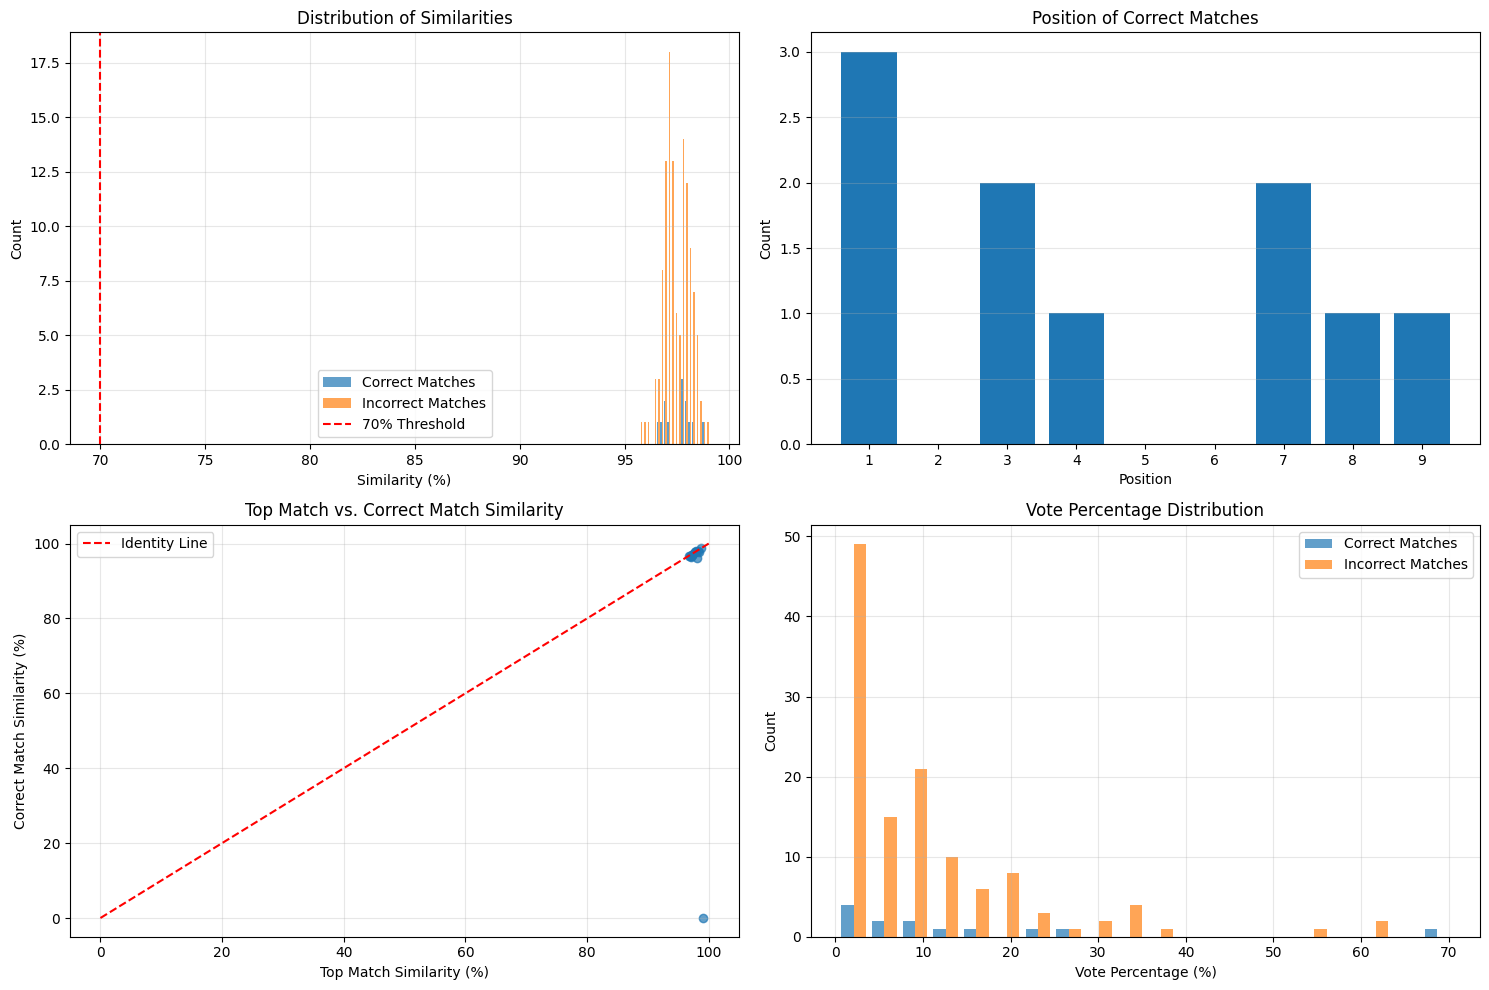


Evaluation Summary:


,query_key,correct_in_top_k,correct_match_position,top_match_similarity,top_match_is_correct
0,000_YzHOD9t1fKM,True,9,96.961445,False
1,001_xVknxiEDy-s,False,-1,97.489664,False
2,002_izixWy82qLs,False,-1,99.032109,False
3,003_ZupxakzVLEk,False,-1,97.310108,False
4,004_MnfnAptvNQ,True,1,97.815123,True
5,005_CUKrxK3WH-A,True,7,97.332272,False
6,006_e5LH6WIIlSs,True,3,97.903801,False
7,007_eQ7YB3rgAmA,False,-1,97.143667,False
8,008_juCoUIB92h8,True,7,96.722720,False
9,009_lAwqPWYN2UU,True,1,97.723625,True


In [14]:
# Call the KNN evaluation function
results_df, eval_df = evaluate_with_knn(
    normalize_vectors=True,  # Apply normalization to fingerprint vectors
    k=10,                     # Find 5 nearest neighbors
    similarity_threshold=70  # Use 70% as threshold for good matches
)

# To examine the results in more detail
print("\nEvaluation Summary:")
display(eval_df[['query_key', 'correct_in_top_k', 'correct_match_position', 
                'top_match_similarity', 'top_match_is_correct']].head(10))

# Save results if desired
results_df.to_csv("results/knn_match_results.csv", index=False)
eval_df.to_csv("results/knn_eval_metrics.csv", index=False)